## 1D PIC (evolution_version) thermal heating

Here we compute the 1D version of PIC. 
The distribution we use corresponds to a particles in a thermal bath with a given temperature.
The distribution is:

$$
f(x,v) = \frac{N}{L} \sqrt{\frac{\theta}{2\pi}} e^{-\frac{v^2}{2\theta}}
$$


In [1]:
#using DifferentialEquations
using Plots
using Statistics
using FFTW
FFTW.set_provider!("mkl")
import Pkg; Pkg.add("FileIO")
using FileIO
using Base.Threads
using Distributions

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


Helper functions are defined in this file.

In [2]:
include("aux_functions.jl")

reorder_particles!

In [3]:
run_name = "long_"
order = 5
const L = 5
#N = 80000
const N = 20000
const J = 50
exp_Theta = 5
exp_t = 5
θ = 10.0^(-exp_Theta)
t = 0.0
t_f = 10.0^(exp_t)
M = 1_000_001
M_g = 1000 + 1 #number of outputs, starting from the initial data
dt = t_f / (M-1)
t_i = 0.0
#M = convert(Int64,t_f/dt)
#M=1
const κ = 2π/L # for Fourier Transform
dx = L/J
x = [dx*(i-1) for i in 1:J] ;
p = (L, N, J, κ, dx, order)

println("t_f = $(t_f), M = $M, dt = $(dt), exp_Theta = $(exp_Theta)")

animation = false

run_name = run_name * "t$(convert(Int,t_f))_L$(L)_N2_5_J$(J)_M$(M)_o$(order)_T$(exp_Theta)"
println(run_name)

t_f = 100000.0, M = 1000001, dt = 0.1, exp_Theta = 5
long_t100000_L5_N2_5_J50_M1000001_o5_T5


We have some extra quantities that are proper of the plasma:

The plasma frequency and the Debye temperature:

The plasma frequency is adjusted so that it is unit in with respect to the time units 
taken, space it taken so that the speed of light is one. 
$$
\omega_p^2 = 1
$$

This implies that the background density is $N/L$

In the paper they say the temperature is set to $\theta_D = dx^2$. 

This I don't understand yet.

$$
\lambda_D^2 := \frac{\epsilon_0 \theta_D L}{e^2 N_e} = \frac{\theta_D L}{N_e}
$$

If we set $\lambda_D = dx$ then, 

$$
\theta_D = \frac{N_e dx^2}{L} = \frac{N_e L}{J^2}
$$

For N = 20000, L = 5, J = 50, $\theta_D = 


We build the initial data:

In [4]:
E = zeros(J)
ϕ = zeros(J)
n = zeros(J) #charge density
S = zeros(J) #carge current
du = zeros(2*N+J); # contains r, v and E


In [5]:
par_dis = load("Initial_Distributions/par_dis_L5_N2_5_theta00001.jld2", "par_dis");

@assert length(par_dis) ÷ 2 == N

With the particle distribution we construct the initial data for the electric field. For that first we compute de density, using different types of particles (order).

In [6]:
@time get_density!(par_dis, n, p)
n0 = N/L
#get_ϕ!(ϕ, -n/n0 .+ 1., κ) # chenge the sign here to make it consistent with charge conservation and the time derivative of E
@time get_ϕ!(ϕ, n/n0 .- 1., κ)
@time get_E_from_ϕ!(ϕ,E,dx)
u = [par_dis;E];
length(u)

  0.098972 seconds (383.63 k allocations: 21.417 MiB, 9.78% gc time, 85.04% compilation time)
  0.674810 seconds (2.05 M allocations: 112.081 MiB, 3.57% gc time, 91.29% compilation time)
  0.013087 seconds (19.60 k allocations: 1.067 MiB, 99.90% compilation time)


40050

### What follows are characterizations of the initial data properties.

In [7]:
@time get_current!(u, S, p)

@time Coordinate_test(u[1:N],L)

println("n_total = $(sum(n .- n0))")
println("v_total = $(sum(u[N+1:2N]))")
println("E_total = $(sum(E))")

println("S_total = $(sum(S))")

  0.043101 seconds (80.24 k allocations: 4.322 MiB, 65.28% compilation time)
  0.084245 seconds (163.11 k allocations: 8.923 MiB, 99.93% compilation time)
n_total = -4.18367562815547e-11
v_total = -2.1080002764454386
E_total = 6.938893903907228e-18
S_total = -21.080002764454413


Compute the initial density, potential and electric field.

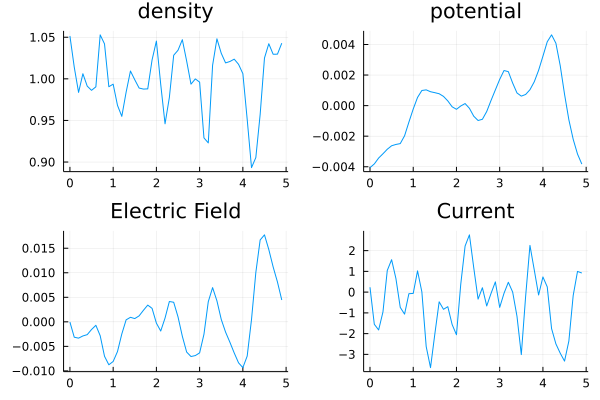

In [8]:
plot(layout=(2,2))
plot!(subplot=1,x,n/n0, title = "density", legend = :false)
plot!(subplot=2,x,ϕ, title = "potential", legend = :false)
plot!(subplot=3,x,E, title = "Electric Field", legend = :false)
plot!(subplot=4,x,S, title = "Current", legend = :false)

Check the histograms for the initial positions and velocities.

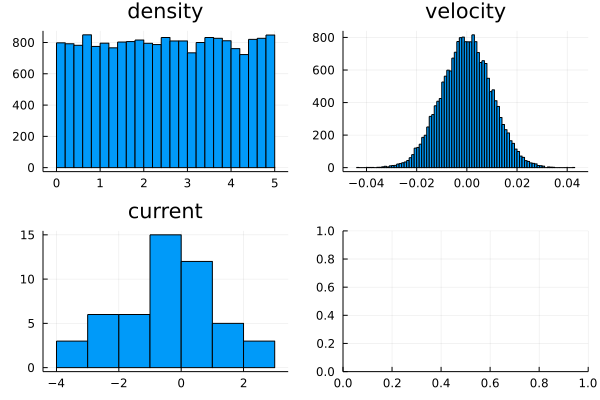

In [9]:
plot(layout=(2,2))
histogram!(subplot=1,u[1:N], title = "density", legend = :false)
histogram!(subplot=2,u[N+1:2*N], title = "velocity", legend = :false)

histogram!(subplot=3,S, title = "current", legend = :false)

## TIME Evolution: 

Now we make the time evolution:

1. we define parameters and vectors where to upload data to study the time evolution: Kinetic Energy, Electric field Energy, Total Electric field, total velocity (momentum), total density, total charge current.

2. we save a vector with the particle phase space, this can be a lot of memory!

In [10]:
if nthreads() > 1
TS = zeros(J, nthreads())
p_RHSC = (N, J, L, dx, order, n, S, du, get_density!, get_current_threads!, Interpolate_2, TS) ;
else
p_RHSC = (N, J, L, dx, order, n, S, du, get_density!, get_current!, Interpolate_2) ;
end

Energy_K = zeros(M_g)
Energy_E = zeros(M_g)
E_T = zeros(M_g)
v_T = zeros(M_g)
D_T = zeros(M_g)
S_T = zeros(M_g)
T = zeros(M_g)
if animation
par = zeros(M_g,2N)
end
Energy_K[1], Energy_E[1]  = get_energy(u,(L, N, J))
E_T[1] = sum(u[2N+1:end])
v_T[1] = sum(u[N+1:2N])
get_density!(u, n, p)
get_current!(u, S, p)
D_T[1] = sum(n)/n0/J - 1
S_T[1] = sum(S)/n0/J
T[1] = var(u[N+1:2N])
if animation
par[1,:] = u[1:2N]
end



t = 0.0
j = 1



1

In [ ]:

for k in 2:(M+1)
  RK4_Step!(RHSC,u,t,dt,p_RHSC)
  u = [make_periodic!(u[1:N],L); u[N+1:end]]
  #filter_constant!(u[2N+1:end])
  t = t + dt
  if (k-1) % (M÷(M_g-1)) == 0
    j = j+1
    #scatter(plt, u[1:N], u[N+1:2*N])
    Energy_K[j], Energy_E[j] = get_energy(u,(L, N, J))
    E_T[j] = sum(u[2N+1:end])
    v_T[j] = sum(u[N+1:2N])
    get_density!(u, n, p)
    get_current!(u, S, p)
    D_T[j] = sum(n)/n0/J - 1
    S_T[j] = sum(S)/n0/J
    T[j] = var(u[N+1:2N])
    println("j = $j , t = $t, k = $k, nthreads = $(nthreads())")
    if animation
    par[j,:] = u[1:2N]
    end
  end
end

@time results:

M=401
t=40
N = 20000
J = 50
L = 5

const order 5 interpolation_2:  33.584136 seconds (51.33 k allocations: 2.456 GiB, 0.69% gc time)

const order 5 interpolation_1:  30. sec

order 5 interpolation_2: 31.499545 seconds (51.33 k allocations: 2.456 GiB, 0.86% gc time) 

order 1 interpolation_2: 7.579297 seconds (51.33 k allocations: 2.456 GiB, 3.12% gc time)

order 3 interpolation_2: 11.414688 seconds (51.33 k allocations: 2.456 GiB, 1.99% gc time)

order 5 interpolation_2: 32.217357 seconds (51.33 k allocations: 2.456 GiB, 0.70% gc time)

order 5 interpolation_2 no-filter-const: 33.524110 seconds (18.85 k allocations: 2.454 GiB, 0.76% gc time)

There are other time results in current_density_check.ipynb

## Studying the solutions: 

### Energy:

In [ ]:
plot(abs.(Energy_K[2:end] .- Energy_K[1]), title = "Energy conservation", label = "Kinetic Energy"
#, legend = :outertopright
, legend = :bottomright)
plot!(abs.(Energy_E[2:end] .- Energy_E[1]), label = "|Electric Energy|")
plot!(abs.(Energy_K[2:end]  + Energy_E[2:end] .- (Energy_K[1]+Energy_E[1])) ./ (Energy_K[1]+Energy_E[1]) , yscale=:log10, xscale=:log10, label = "Total Energy / Initial Energy -1 ")
png(run_name * "energy_conservation")

In [ ]:
abs.(Energy_K[end]  + Energy_E[end] .- (Energy_K[1]+Energy_E[1])) ./ (Energy_K[1]+Energy_E[1])

In [ ]:
plot(T, label= "θ", title = "Temperature = var", legend = false)
png(run_name * "temperature")

In [ ]:
T[end]

We save the data:

In [ ]:
n_F = zeros(J)
S_F = zeros(J)
get_density!(u, n_F, p)
get_current!(u, S_F, p)
save(run_name * "results.jld2", Dict("p" => p, "Energy_E" => Energy_E, "Energy_K" => Energy_K, "E_f" => u[2N+1:end], "n_F" => n_F, "S_F" => S_F, "E_T"=> E_T, "v_T" => v_T, "S_T" => S_T, "D_T" => D_T, "T" => T))

| time | order | energy | theta |
|------|-------|--------|-------|
|  40  |  1    | 7.4e-7 | 0.009978|
|  40  |  3    | 7.9e-8 | 0.009979 |
|  40  |  5    | 1.1e-7 | 0.009979 |
|  4000|  1    | 7.6e-5 | 0.009978 |
|  4000|  3    | 7.2e-6 | 0.010086 |
|  4000|  5    | 1.0e-5 | 0.010031 |
|  4e6 |  1    | 0.0360 | 0.010119 |


## Total Quantities

In [ ]:
plot(layout=(2,2))
plot!(subplot=1,E_T,title="Total Electric Field")
plot!(subplot=2,v_T./N, title="Total velocity")
plot!(subplot=3,D_T,title = "Total density")
plot!(subplot=4,S_T,title = "Total Current")
png(run_name * "totals")

In [ ]:
E_F = zeros(J)
ϕ_F = zeros(J)
n_F = zeros(J)
get_density!(u, n_F, p)
n0 = N/L
get_ϕ!(ϕ_F, n_F/n0 .+ 1, κ)
#get_ϕ!(ϕ_F, n_F .- n0, κ)
get_E_from_ϕ!(ϕ_F,E_F,dx)
plot(x,u[2N+1:end], label = "dynamical", title="Electric Field with order = $(order)")
plot!(x,E_F,label="from constraint", ls=:dash)
#t_f = 40
png(run_name * "E")

In [ ]:
println("averaged total E field = $(sum(E_F))")
println("E_total = $(sum(u[2N+1:end])/J)")
println("Total velocity = $(sum(u[N+1:2N])/N)")
println("Total Charge = $(sum(n_F .- n0))")
println("Final Energy = $(get_energy(u,(L, N, J)))")
get_current!(u, S, p)
println("Total_current = $(sum(S)/J)")

In [ ]:
plot(x,u[2N+1:end]-E_F, label = "difference", title="Electric Field")
png(run_name * "electric_diff")

In [ ]:
Plots.scatter(u[1:N],u[N+1:2N]
#, thickness_scaling = 0.3
, markersize = 0.3
, title = "phase-space", legend =:false)
png(run_name * "ps")

In [ ]:
anim = @animate for i = 1:M_g
    scatter(par[i,1:N], par[i,N+1:2N]
    , markersize = 0.3
    , title = "phase-space"
    , legend=false
    , ylim = (-0.3,0.3)
    , xlim = (0,5)
    )
end
 
gif(anim, run_name * "ps_fps5.gif", fps = 5)

In [ ]:
load(run_name * "results.jld2", "S_F")